# Lab05: Spike‑Timing‑Dependent Plasticity (STDP)
Welcome to the hands‑on lab for exploring STDP!  
In this notebook you will:
1. Implement the Song–Abbott–Miller leaky integrate‑and‑fire (LIF) neuron model with pair‑based STDP.  
2. Generate several kinds of presynaptic spike trains.  
3. Run three guided experiments and interpret the results.

## Neuron and synapse model
We follow the parameters reported by **Song et al. 2000** for their current‑based LIF neuron [τ_m = 20 ms, V_rest = −70 mV, V_th = −54 mV, V_reset = −60 mV, τ_ex = τ_in = 5 ms, g_max = 0.015 (dimensionless)].  Weights are bounded in **[0, g_max]** and updated with the classical pair‑based STDP rule:
$$\Delta g = \begin{cases}
A_+\,e^{\Delta t/\tau_+} & \Delta t<0\\[2pt]
-A_-\,e^{-\Delta t/\tau_-} & \Delta t\ge0\end{cases}$$
with $\tau_+=\tau_-\;{=}$ 20 ms, $A_+=0.005\,g_{\max}$ and $A_-/A_+=1.05$.

## Learning goals
After completing the notebook you should be able to:
* Explain how the relative timing of pre‑ and postsynaptic spikes drives synaptic potentiation or depression.
* Show that STDP favors inputs with shorter latencies.
* Describe how STDP can stabilize a neuron’s output rate across a wide range of input rates.
* Discuss whether STDP can learn rate codes, too.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For reproducibility
rng = np.random.default_rng(seed=42)

# plot your spike data
def plot_spikes(spike_trains, T):
    """
    Quick raster plot.

    Parameters
    ----------
    spike_trains : array-like of 1-D numpy arrays
        spike_trains[i] contains the spike times (s) for neuron i.
    T : float
        Maximum time for x-axis (s).
    """
    plt.eventplot(spike_trains, linelengths=0.3, color='k')
    plt.xlim(0, T)
    plt.ylim(-0.5, len(spike_trains) - 0.5)
    plt.xlabel('time (s)')
    plt.ylabel('neuron index')
    plt.show()

## Task 1:

Implement the neuron model response and STDP update for the simple latency spike input below. Cycle through the input multiple times to see how STDP adapts the weights.

You can safely ignore inhibitory components of the model here.

2


ValueError: positions must be one-dimensional

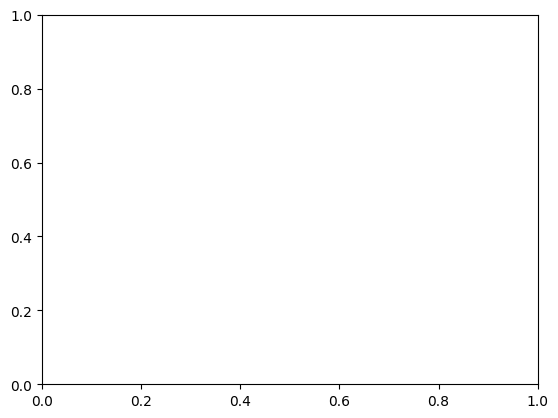

In [39]:
#  Simulation & model parameters 
dt       = 1e-3       # simulation time step [s]
tau_m    = 20e-3      # membrane time constant [s]
v_rest   = -0.070     # resting potential [V]
v_reset  = -0.060     # reset potential [V]
v_th     = -0.054     # spike threshold [V]
tau_ex   = 5e-3       # excitatory synaptic decay [s]
tau_in   = 5e-3       # inhibitory synaptic decay [s]

g_max    = 0.5     # max excitatory weight (dimensionless w.r.t. leak conductance)
g_in     = 0.05       # fixed inhibitory weight per spike

# STDP constants
tau_plus  = 20e-3
tau_minus = 20e-3
A_plus    = 0.005     # fraction of g_max added per causal pair
A_minus   = 1.05*A_plus

# experiment
latency_spikes = np.array([[0.005],
                           [0.010], 
                           [0.015], 
                           [0.020], 
                           [0.025]])               
T            = 0.050                               # 50 ms cycle
cycles       = 10
N_exc        = 5

e_ex = 0.0
e_in = -0.070



def run_simple(exc_spike_trains, g, T):
    """Simulate the LIF neuron for T seconds.
    exc_spike_trains – list of numpy arrays with spike times for each excitatory synapse.
    Returns (postsynaptic spike times, final weights list)."""
    # tau_m*dV/dt = V_rest – V + g_ex (t)(E_ex – V) + g_in (t)(E_in – V)
    steps_per_T = T/dt
    
    postsyn_spk_times = []
    final_weights = []
    v = v_rest # initial V
    # all conductances 0 for now
    g_ex = 0
    # g_a = np.zeros(N_exc) # of size len(exc_spike_trains), might be in g I guess
    P = np.zeros(N_exc)
    M = 0.0
    
    for step in range(int(steps_per_T)):
        t = step*dt
        for a, spks in enumerate(exc_spike_trains):
            # all spikes for a synapse a that happened in the last timestep
            if spks[0] <= t and spks.size: # they need to be ordered and not None
                g_ex += g[a]
                P[a] += A_plus # update ltp trace
                g[a] = max(g[a] + M * g_max, 0.0)
                np.delete(exc_spike_trains, 0)
                
        # decay conductances
        g_ex -= (dt / tau_ex)
        
        # decay pre/posttraces. we just decay it already and then it is useful once the future spike actually occurs
        M -= M / tau_minus * dt
        P -= P / tau_plus * dt
        
        # update membrane potential
        # at each timestep, calculate V:
        v = v + dt/tau_m * (v_rest - v + g_ex * (e_ex - v) + g_in * (e_in - v))
        # pascal version: v + (v_rest - v - g_ex * v) / tau_m * dt # E_inh = V_rest
        
        # check if we spike
        if v >= v_th:
            v = v_reset
            post_spike_history.append(t)
            M -= A_minus
            g += P*g_max
            np.minimum(g, g_max, out=g)
    
        # notes
        # g_ex is the sum of all the g_a s (collects all the contributions, running sum of all conductances)
        # g_ex also continuously decays due to the closing of the channels 
        # g_a is the weight of each synapse a
        
    return np.array(post_spike_history, dtype=object), g

        
# run_simple cycles times:
# -- run the experiment --
g = np.full(N_exc, 0.1 * g_max) # small initial weights
g_history = [g.copy()] # collect weights
post_spike_history = [] # collect output times
for cycle in range(cycles):
    post_spikes, g = run_simple(latency_spikes, g, T) # TODO update latency spikes correctly
    post_spike_history.append(post_spikes)
    g_history.append(g)   
    
print(len(post_spike_history[2]))
plot_spikes(post_spike_history, T)

## Task 2:
We are now going to implement the simulation experiment over different input rates.

1. Draw Poisson spikes (feel free to plot to check)
2. Update your simulation to include inhibitionas well as excitation. The simulation should start with all weights set to g_max.
3. Run your simulation for 1s and report the final STDP adapted weights. 

In [ ]:
g_max    = 0.15      # max excitatory weight (dimensionless w.r.t. leak conductance)
g_in     = 0.5        # fixed inhibitory weight per spike


# Network size
N_exc  = 250          # number of excitatory synapses (reduced for speed)
N_inh  = 75           # number of inhibitory synapses

# these are adapted by pascal due to computational cost and such

In [ ]:
def poisson_spike_times(rate, T, rng=rng):
    n_spikes = rng.poisson(rate * T) # the rate is in hertz
    return np.sort(rng.random(n_spikes * T) # poission is uniformly distributed. sort to get the spikes in order

def run_sim(exc_spike_trains, inh_spike_trains, T, g_multiple = 1.0):
    """Simulate the LIF neuron for T seconds.
    exc_spike_trains – list of numpy arrays with spike times for each excitatory synapse.
    inh_spike_trains – list of numpy arrays with spike times for each excitatory synapse..
    Returns (postsynaptic spike times, final weights list)."""
    pass
                   # use while loops to go over all spikes (for exc. and inh. spike trains respectively)
                   # delete processed spikes (spks = spks[1:])
                   
                   # after the loops, decay conductances, pre/post traces, update membrane potential, etc like above
                   

In [ ]:
# Parameters of this expeirment.
T_sim   = 200.0     # seconds per experiment (increase for better convergence)
rates   = [10, 20, 40]  # Hz
inh_rate = 10      # Hz per inhibitory synapse

all_results = {}
# get poisson exc_trains and inh_trains
# get post_spk and w_final from run_sim
# all_results[rate] = {post_spk, w_final}

pass


## 5 · Task 4 – Rate coding

We will now check what happens if the rate of different inpout neurons is informative. Your first 50 input neurons are going to fire at 40Hz (Poisson), whereas remaining 200 inp

now split the 250 excitatory afferents into two groups:

* **50 “high‑rate” inputs** – Poisson at 40 Hz  
* **200 “low‑rate” inputs** – Poisson at 5 Hz  

All other parameters remain the same.  
After running STDP for 10 s, inspect the weight distributions of the two groups.


In [ ]:
# --- Rate‑code experiment ---
T_sim      = 1000.0
high_rate  = 40   # Hz
low_rate   = 5    # Hz
n_high     = 50
n_low      = N_exc - n_high

# exc_trains = ([highrate poisson thing] + [lowrate poisson thing])
# intended finding: mean stays, but low has bunch of outliers 
# high rate stuff gets whole lot of ltd. poisson has no temp. structure
# play around with parameters 

pass